# Example 1 - linear regression

Using both Stan and pyMC for the same simple model. The point of this series of tutorials is to find out which of the two libraries will be kept in the published version of Poem.

* Data loading and preprocessing
* Model definition and choice of prior
* Model fitting and diagnostics
* Model checking and prediction

This is a M&V tutorial: as a last step, we will calculate energy savings by substracting "post" consumption from the consumption predicted by the model trained on the "pre" period.

In [1]:
# All imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import arviz as az

# Data

In [2]:
df = pd.read_csv("../data/pmva.csv")
df.head()

,observation,consumption,HDD,CLASSDAYS,period
0,1,321120,12.7,0.0,pre
1,2,335520,19.4,6.0,pre
2,3,412560,147.6,20.0,pre
3,4,394560,353.4,20.0,pre
4,5,424080,526.7,20.0,pre


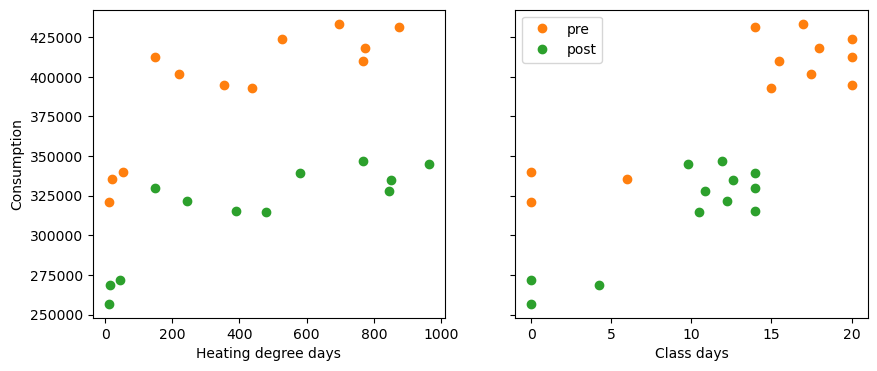

In [3]:
df_pre  = df[df.period == 'pre']
df_post = df[df.period == 'post']

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax[0].plot(df_pre['HDD'],  df_pre['consumption'],  marker="o", ls="", color="C1")
ax[0].plot(df_post['HDD'], df_post['consumption'], marker="o", ls="", color="C2")
ax[1].plot(df_pre['CLASSDAYS'],  df_pre['consumption'],  marker="o", ls="", color="C1", label="pre")
ax[1].plot(df_post['CLASSDAYS'], df_post['consumption'], marker="o", ls="", color="C2", label="post")
ax[0].set_xlabel('Heating degree days')
ax[0].set_ylabel('Consumption')
ax[1].set_xlabel('Class days')
ax[1].legend()

# Model specification and fitting with Stan

Pystan requires Linux, which may not be used by all Poem users. It is also no longer under development. We will use cmdstanpy instead:
https://mc-stan.org/cmdstanpy/index.html

In [4]:
from cmdstanpy import CmdStanModel

model = CmdStanModel(stan_file='../models_stan/linearregression.stan')

09:24:25 - cmdstanpy - INFO - compiling stan file /media/simon/donnees/Boulot/science/Git/poem/models_stan/linearregression.stan to exe file /media/simon/donnees/Boulot/science/Git/poem/models_stan/linearregression
09:26:15 - cmdstanpy - INFO - compiled model executable: /media/simon/donnees/Boulot/science/Git/poem/models_stan/linearregression


The sample() method is used to do Bayesian inference over the model conditioned on data using using Hamiltonian Monte Carlo (HMC) sampling. It runs Stan’s HMC-NUTS sampler on the model and data and returns a CmdStanMCMC object. The data can be specified either as a filepath or a Python dictionary.
* CmdStan is a file-based interface, therefore all model input and initialization data must be supplied as JSON files, as described in the [CmdStan User’s Guide](https://mc-stan.org/docs/cmdstan-guide/json_apdx.html#creating-json-files).
* CmdStanPy inference methods allow inputs and initializations to be specified as in-memory Python dictionary objects which are then converted to JSON.

In [ ]:
model_data = {
    "N": len(df_pre),
    "K": 2,
    "x": df_pre[['HDD', 'CLASSDAYS']].values,
    "y": df_pre['consumption'].values,
}

fit = model.sample(data=model_data)

10:50:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:09 - cmdstanpy - INFO - CmdStan done processing.


[CmdStan utilities: stansummary, diagnose](https://mc-stan.org/cmdstanpy/users-guide/hello_world.html#cmdstan-utilities-stansummary-diagnose)
* CmdStan is distributed with a posterior analysis utility stansummary that reads the outputs of all chains and computes summary statistics for all sampler and model parameters and quantities of interest. The CmdStanMCMC method summary() runs this utility and returns summaries of the total joint log-probability density lp__ plus all model parameters and quantities of interest in a pandas.DataFrame:
* CmdStan is distributed with a second posterior analysis utility diagnose which analyzes the per-draw sampler parameters across all chains looking for potential problems which indicate that the sample isn’t a representative sample from the posterior. The diagnose() method runs this utility and prints the output to the console.

In [42]:
fs = fit.summary(percentiles=(5, 50, 95))
fs.loc[['alpha', 'beta[1]', 'beta[2]', 'sigma', 'lp__']]
# print(fit.diagnose())

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
alpha,325228.00000,225.414000,9506.10000,309494.0000,325485.000,340363.0000,1778.46000,1157.10000,1.00001
beta[1],56.83840,0.402185,16.82880,29.1891,56.251,84.7587,1750.87000,1139.15000,1.00212
beta[2],3280.94000,18.404800,734.98700,2064.7800,3290.850,4465.4200,1594.77000,1037.59000,1.00326
sigma,14134.34074,117.038510,4206.82471,9088.5700,13337.200,21743.7000,1291.96645,840.57674,1.00063
lp__,-110.14800,0.061194,1.77162,-113.5330,-109.740,-108.0900,838.16100,545.32300,1.00083


## Results

[Accessing the results of a CmdStanPy fit](https://mc-stan.org/cmdstanpy/users-guide/hello_world.html#accessing-the-results)

The CmdStanMCMC object provides the following accessor methods:
* stan_variable(): returns an numpy.ndarray whose structure corresponds to the Stan program variable structure
* stan_variables(): returns an Python dictionary mapping the Stan program variable names to the corresponding numpy.ndarray.
* draws(): returns a numpy.ndarray which is either a 3-D array draws X chains X CSV columns, or a 2-D array draws X columns, where the chains are concatenated into a single column. The argument vars can be used to restrict this to just the columns for one or more variables.
* draws_pd(): returns a pandas.DataFrame over all columns in the Stan CSV file. The argument vars can be used to restrict this to one or more variables.
* draws_xr(): returns an xarray.Dataset which maps model variable names to their respective values. The argument vars can be used to restrict this to one or more variables.
* method_variables(): returns a Python dictionary over the sampler diagnostic/information output columns which by convention end in __, e.g., lp__.


In [43]:
res_pd = fit.draws_pd()
res_xr = fit.draws_xr()

## Using ArviZ with CmdStanPy

[Documentation here](https://python.arviz.org/en/stable/getting_started/Introduction.html#cmdstanpy-integration)

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

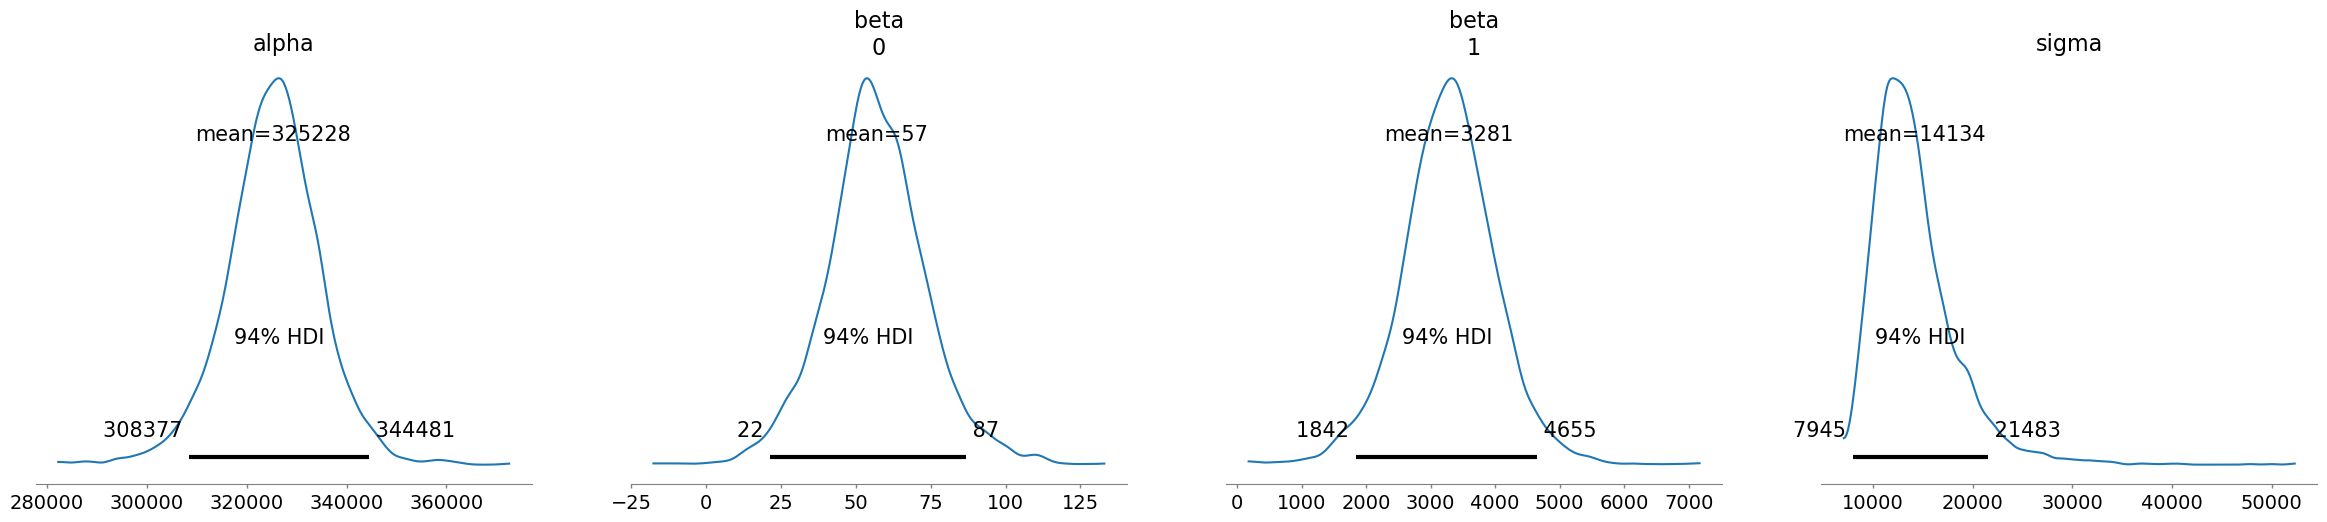

In [44]:
az.plot_posterior(fit, var_names=["alpha", "beta", "sigma"])

To make the most out of ArviZ however, it is recommended to convert the results to InferenceData. This will ensure all variables are assigned to the right groups and also gives you the option of labeling the data.

This is the inference output in xarray format:

In [45]:
res_xr

<xarray.Dataset> Size: 904kB
Dimensions:  (draw: 1000, chain: 4, beta_dim_0: 2, log_lik_dim_0: 12,
              y_hat_dim_0: 12)
Coordinates:
  * chain    (chain) int64 32B 1 2 3 4
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Dimensions without coordinates: beta_dim_0, log_lik_dim_0, y_hat_dim_0
Data variables:
    alpha    (chain, draw) float64 32kB 3.263e+05 3.335e+05 ... 3.289e+05
    beta     (chain, draw, beta_dim_0) float64 64kB 59.04 ... 3.211e+03
    sigma    (chain, draw) float64 32kB 1.093e+04 1.246e+04 ... 1.308e+04
    log_lik  (chain, draw, log_lik_dim_0) float64 384kB -10.37 -10.86 ... -10.57
    y_hat    (chain, draw, y_hat_dim_0) float64 384kB 3.309e+05 ... 3.225e+05
Attributes:
    stan_version:        2.33.0
    model:               linearregression_model
    num_draws_sampling:  1000

Now we try to create an arviz.InferenceData object to make full use of ArviZ:

In [58]:
idata = az.from_cmdstanpy(
    posterior = fit,
    posterior_predictive="y_hat",
    observed_data={"y": df_pre['consumption'].values},
    constant_data={"x": df_pre[['HDD', 'CLASSDAYS']].values},
    log_likelihood="log_lik",
    #coords={"observations": len(df_pre), "features": 2},
    dims={
        "y_hat": ["observations"],
        "log_lik": ["observations"],
        "y": ["observations"],
        #"x": ["observations, features"],
        "beta": ["features"]
        },
)

In [59]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

# PyMC